In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Data processing
Imports data from the defined cases.

Imported data includes power and price.
Additionally, creates a list of the numerical indexes for beginnings of months.

Default cases: 
- `baseline`: a run with a constant tolerance of 1 degrees. It serves as baseline data and is included in the repository for reference. If changes are made to the framework, it should be replaced or removed.
- `recent`: case pulls the most recent data from the simulation. If the results are interesting, this case's data should be saved under a new folder.


In [2]:
power = {
    'baseline': 'data_baseline',
    'tolerant': 'data_high_tol',
    'opportune': 'data_opportune',
    'recent': 'gridlab-d'
}
prices = pd.DataFrame({})

for case, path in power.items():
    _power = pd.read_csv(f'{path}/power_log.csv', skiprows = 7, index_col = 0)
    _power.index.name = _power.index.name.replace('# ', '')
    _power.columns = _power.columns.str.replace(':measured_real_power', '')
    _power.index = pd.DatetimeIndex(_power.index.str.replace('PST|PDT', '', regex=True))
    power[case] = _power/1e3
    
    _price = pd.read_csv(f'{path}/price_log.csv')[::3]['price']
    prices[case] = list(_price)

prices.index = pd.DatetimeIndex(power['baseline'].index.copy())


# Creates a list of the numerical indexes for the beginnings of months.
# The last moment of December is included, as well.
temp_df = power['baseline'].index
month_index = [0]
for m in range(2,13):
    month_index.append(temp_df.get_loc(f'2000-{m:02d}-01 00:00:00'))
month_index.append(len(temp_df)-1)


# Clear temporary variables for clarity.
del case
del path
del temp_df
del m


### Calculate energy and cost
Two cells for further data processing:
- Converts power and price data into cost (in USD). Additionally, monthly costs are computed.
- Converts 15-minute kW power data into hourly kWh usage.
- - This cell is currently costly to run. Probably fixable?

In [9]:
cost = {}

for case, data in power.items():
    _cost = {
        key: value * list(prices[case])/100
        for key, value in data.items()
    }
    cost[case] = pd.DataFrame(_cost)
    cost[case].index = data.index.copy()

cost2 = {}
for case, data in cost.items():
    _cost = {
        col: [sum(data[col])/4]
        for col in data.columns
    }
    cost2[case] = pd.DataFrame(_cost)

# Sums costs for each individual month.
monthly_costs = {}
for case, data in cost.items():
    monthly_costs[case] = []
    for m in range(0, len(month_index)-1):
        _calc = round(sum(data['N2'].iloc[month_index[m]:month_index[m+1]])/4, 2)
        monthly_costs[case].append(_calc)

del _cost
del _calc
del m
del case
del data

In [3]:
energy = {}

for case, data in power.items():
    _energy = {
        key:[
            sum(value[4*i:4*(i+1)])/4
            for i in range(int(len(value)/4))
            ]
        for key, value in data.items()
        }
    energy[case] = pd.DataFrame(_energy)
    energy[case].index = pd.to_datetime(data.index[0::4]).copy()

del _energy
del case
del data

In [12]:
# Write hourly data to .xlsx file
# Change False to True to activate cell.

if False:
    for case, frame in cost2.items():
        frame.to_csv(f'cost_{case}.csv')


if False:
    for case, frame in energy.items():
        _frame = frame.to_csv(f'data_{case}.csv')


### Functions
Just in case data doesn't need to be computed from the beginning

Potentially the mandatory `energy` and `cost` dictionaries could be turned in to functions, to reduce the amount of data processing done at the start.

In [6]:
def aggregator(dataframe, start = 0, stop = -1, step = 96):
    '''
    Aggregates data from a given dataframe into a single representative day.
    '''
    _aggregate = {
        key: [ value.iloc[start + i : stop : step].mean() for i in range(step) ]
        for key, value in dataframe.items()
    }
    return pd.DataFrame(_aggregate, index=pd.to_datetime(dataframe.index[0:step]).copy())

### Calculates the mean and standard deviation for power demand of each node.
Data is used for `supplier.py` and for creating a schedule for `.idf` files.

(Uncomment second box to write data to a `.csv`)

In [7]:
means_lists = {}
for node in power['baseline'].columns:
    node_data = power['baseline'][node]
    mean_data = []
    std_data = []
    for i in range(0, len(month_index)-1):
        current = node_data[month_index[i]:month_index[i+1]]
        mean_data.append(current.mean())
        std_data.append(current.std())

    means_lists[node] = mean_data
    means_lists[f'{node}_std'] = std_data

means = pd.DataFrame(means_lists, index = month_index[:-1])

In [4]:
# Write means to CSV file.
# Change False to True to activate cell.

if False:
    means.to_csv('baseline_mean_data.csv')


In [66]:
# Test box
# (for making sure all the variables work)
# print(means['N3'][month_index[6]]/1e3)
# print(power['uncontrolled']['N3'].iloc[month_index[6]:month_index[6]+96])
# print(cost['uncontrolled']['N3'])
# print(price)
# print(aggregate['baseline']['N2'])


## Graphs

### Secondary transformer (entire circuit) demand
Compare the baseline data to the most recent run.

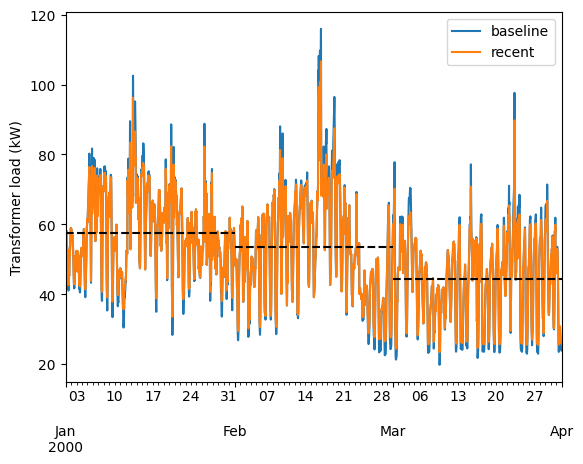

In [8]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(weeks=13)
jan_days = pd.Timedelta(days=31)
feb_days = pd.Timedelta(days=29)

node = 'N2'
start = power['baseline'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()
power['baseline'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
power['recent'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
data_range = [
    power['baseline'][month_index[0]:month_index[1]][node],
    power['baseline'][month_index[1]:month_index[2]][node],
    power['baseline'][month_index[2]:month_index[3]][node]
]
ax.hlines(
    y=[data_range[0].mean(),
       data_range[1].mean(),
       data_range[2].mean()],
    xmin=[start,
          start+jan_days,
          start+jan_days+feb_days],
    xmax=[start+jan_days,
          start+jan_days+feb_days,
          stop], 
    linestyles='--', 
    colors='black'
)

ax.legend(['baseline', 'recent'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')

plt.show()

### Focused view of demand
2-day windows of time for baseline, tolerant, and opportune scenarios.
Default set to view data for the entire circuit.
Two dates (first week of Jan., first week of Jul.) are predefined for viewing.

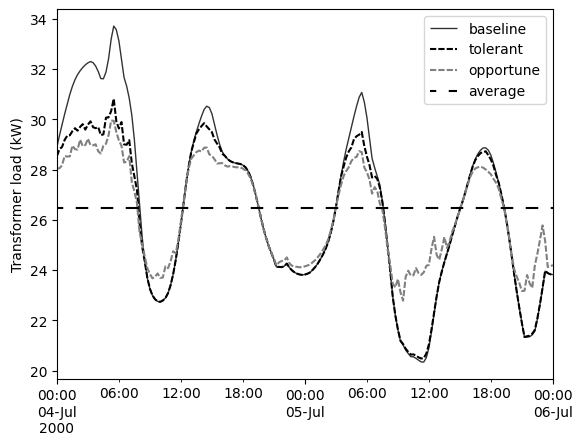

In [9]:
deltaStart = pd.Timedelta(days=7)
deltaStart2 = pd.Timedelta(days=31+29+31+30+31+30+3) 
deltaEnd = pd.Timedelta(days=2)

node = 'N2'
start = power['baseline'].index[0] + deltaStart2
stop = start + deltaEnd

fig, ax = plt.subplots()
power['baseline'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

power['tolerant'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='black'
)

power['opportune'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='gray'
)


data_range = [
    power['baseline'][month_index[0]:month_index[1]][node],
    power['baseline'][month_index[6]:month_index[7]][node]
]
ax.hlines(
    y=[data_range[1].mean()],
    xmin=[start],
    xmax=[stop], 
    linestyles=(3, (6, 6)), 
    colors='black'
)


ax.legend(['baseline', 'tolerant', 'opportune', 'average'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')

plt.show()

6537.49
6272.13
6504.33
---
56.35
56.0
57.2


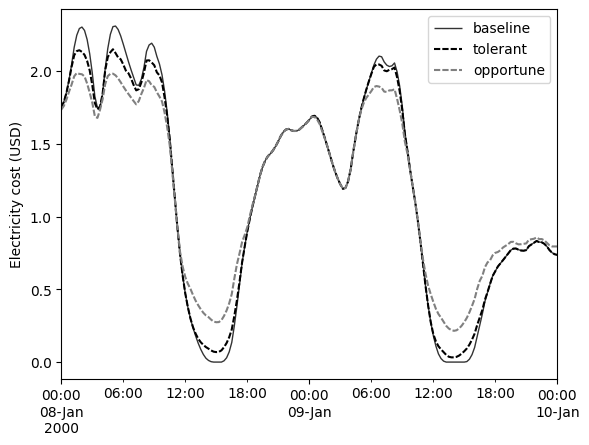

In [44]:
# Node cost graph

node = 'N2'
start = power['baseline'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()

print(round(sum(cost['baseline'][node])/4, 2))
print(round(sum(cost['tolerant'][node])/4, 2))
print(round(sum(cost['opportune'][node])/4, 2))
print('---')
print(round(sum(cost['baseline'][node].loc[start:stop])/4, 2))
print(round(sum(cost['tolerant'][node].loc[start:stop])/4, 2))
print(round(sum(cost['opportune'][node].loc[start:stop])/4, 2))

cost['baseline'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

cost['tolerant'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='black'
)

cost['opportune'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='gray'
)


ax.legend(['baseline', 'tolerant', 'opportune'])
ax.set_ylabel('Electricity cost (USD)')
ax.set_xlabel('')

plt.show()

In [56]:
# Use different line styles rather than colors
# Change both to black
# Printed out versions
# (Run another with different parameters)
#
# Figure 1: winter (1 day)
# Figure 2: summer (1 day)
# Figure 3: bar chart?
# # aggregate demand per-hour for the whole year --> 24 bars
#print(data['power']['N2'].iloc[0])
#print(data['power'].index[0:96])
        

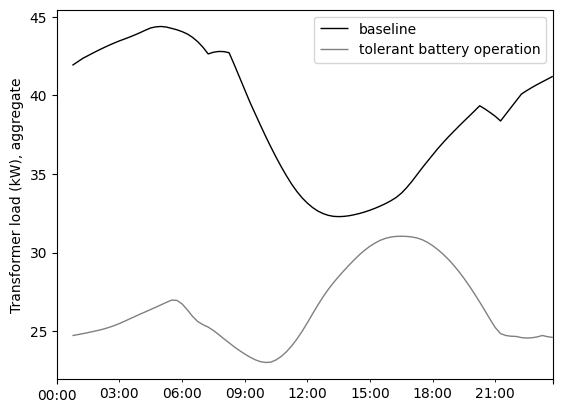

In [65]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(days=1)

node = 'N2'
start = power['baseline'].index[0] + deltaStart
stop = start + deltaEnd

agg_1 = aggregator(power['baseline'])
agg_2 = aggregator(power['baseline'], start = month_index[6], stop = month_index[7])

fig, ax = plt.subplots()
'''
aggregate['baseline'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

aggregate['tolerant'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    #marker='o',
    #markersize=3,
    alpha=1,
    color='black'
)

aggregate['opportune'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    #marker='o',
    #markersize=3,
    alpha=1,
    color='gray'
)
'''
agg_1['N2'].rolling(window=4).mean().plot(
    ax=ax,
    linestyle = (0, ()),
    linewidth = 1,
    color = 'black'
)

agg_2['N2'].rolling(window=4).mean().plot(
    ax=ax,
    linestyle = (0, ()),
    linewidth = 1,
    color = 'gray'
)

ax.legend(['baseline (January)', 'baseline (June)'])
ax.set_ylabel('Transformer load (kW), aggregate')
ax.set_xlabel('')
[locs, labels] = plt.xticks()
labels[0].set_text('00:00')
plt.xticks(locs, labels)

plt.show()

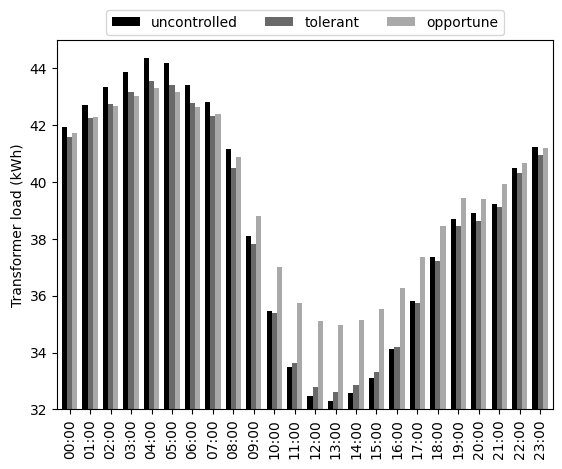

In [340]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(days=1)

node = 'N2'
start = data['baseline'].index[0] + deltaStart
stop = start + deltaEnd

hourly = {}
for key in new_frame:
    hourly[key] = [ sum(times)/4 for times in [ new_frame[key][4*i:4*(i+1)] for i in range(24)] ]
hourly_agg = pd.DataFrame(hourly, index=aggregated.index[0::4].copy())

fig, ax = plt.subplots()

'''
hourly_agg['uncontrolled'].loc[start:stop].plot.bar(
    ax=ax,
    #linestyle=(0, ()),
    #linewidth=1,
    #alpha=0.8,
    color='black',
    width=0.75
)
'''

hourly_agg.plot.bar(
    ax=ax,
    #linestyle=(0, (3, 1)),
    #linewidth=1.5,
    #marker='o',
    #markersize=3,
    #alpha=1,
    color=['black', 'dimgray', 'darkgray'],
    width=0.75
)

ax.legend(['uncontrolled', 'tolerant', 'opportune'], loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3)
ax.set_ylabel('Transformer load (kWh)')
ax.set_xlabel('')
[locs, labels] = plt.xticks()
for i in range(24):
    labels[i].set_text(f'{i:02d}:00')

plt.xticks(locs, labels)

ax.set_ylim(32, 45)

plt.show()

In [ ]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(days=1)

node = 'N2'
start = data['baseline'].index[0] + deltaStart
stop = start + deltaEnd

hourly = {}
for key in new_frame:
    hourly[key] = [ sum(times) for times in [ new_frame[key][4*i:4*(i+1)] for i in range(24)] ]
hourly_agg = pd.DataFrame(hourly, index=aggregated.index[0::4].copy())

fig, ax = plt.subplots()

'''
hourly_agg['uncontrolled'].loc[start:stop].plot.bar(
    ax=ax,
    #linestyle=(0, ()),
    #linewidth=1,
    #alpha=0.8,
    color='black',
    width=0.75
)
'''

hourly_agg.plot.bar(
    ax=ax,
    #linestyle=(0, (3, 1)),
    #linewidth=1.5,
    #marker='o',
    #markersize=3,
    #alpha=1,
    color=['black', 'dimgray', 'darkgray'],
    width=0.75
)

ax.legend(['baseline', 'tolerant', 'opportune'], loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3)
ax.set_ylabel('Transformer load (kWh)')
ax.set_xlabel('')
[locs, labels] = plt.xticks()
for i in range(24):
    labels[i].set_text(f'{i:02d}:00')

plt.xticks(locs, labels)

plt.show()

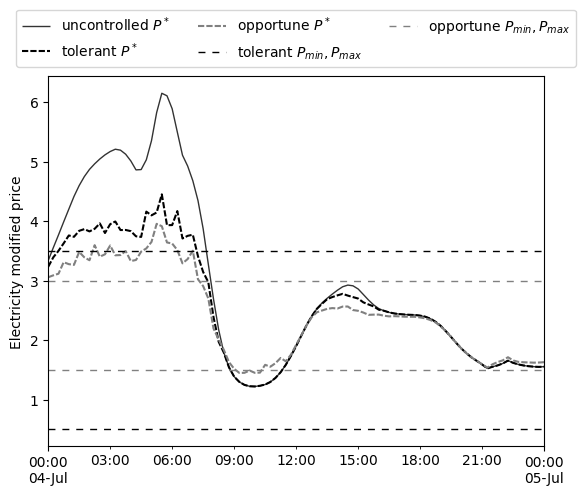

In [341]:
# P* and Pmin Pmax graph
deltaStart = pd.Timedelta(days=7)
deltaStart2 = pd.Timedelta(days=31+29+31+30+31+30+3) 
deltaEnd = pd.Timedelta(days=1)

node = 'N6'
start = data['baseline'].index[0] + deltaStart2
stop = start + deltaEnd

fig, ax = plt.subplots()
costs = {}
for key, value in data.items():
    costs[key] = data[key][node] * prices[key] / (means[node][month_index[6]]/1e3)


costs['baseline'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

costs['tolerant'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='black'
)

costs['opportune'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='gray'
)


#data_range = data['uncontrolled'][node].loc[start:stop]
#data_mean = data_range.mean()

ax.hlines(
    y=[0.5,
       3.5],
    xmin=start,
    xmax=stop,
    linestyles=[(0, (5, 5)),
                (0, (5, 5))],
    linewidth=1,
    colors='black'
)

ax.hlines(
    y=[1.5,
       3.0],
    xmin=start,
    xmax=stop,
    linestyles=[(0, (5, 5)),
                (0, (5, 5))],
    linewidth=1,
    colors='gray'
)


ax.legend([r'baseline $P^*$',
           r'tolerant $P^*$',
           r'opportune $P^*$',
           r'tolerant $P_{min}, P_{max}$',
           r'opportune $P_{min}, P_{max}$'],
           loc='upper center',
           bbox_to_anchor=(0.5,1.2),
           ncol=3)
ax.set_ylabel('Electricity modified price')
ax.set_xlabel('')

plt.show()

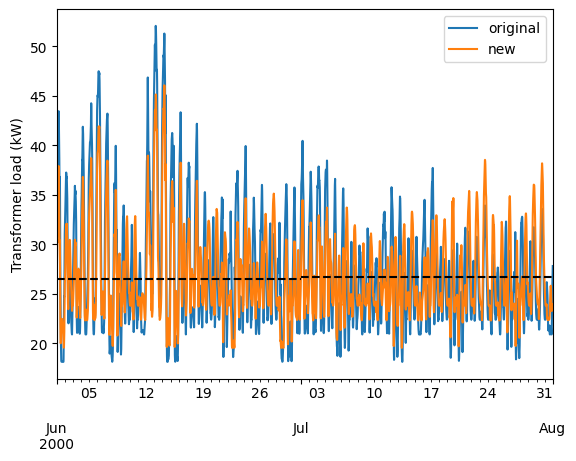

In [15]:
deltaStart = pd.Timedelta(days=31+29+31+30+31)
deltaEnd = pd.Timedelta(days=30+31)
jun_days = pd.Timedelta(days=30)

node = 'N2'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()
#data['power'][node].loc[start:stop].plot(ax=ax)
data['baseline'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
data['power'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
#data['power_old'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
data_range = [
    data['power'][month_index[5]:month_index[6]][node],
    data['power'][month_index[6]:month_index[7]][node]
]
ax.hlines(
    y=[data_range[0].mean(),
       data_range[1].mean()],
    xmin=[start,
          start+jun_days],
    xmax=[start+jun_days,
          stop], 
    linestyles='--', 
    colors='black'
)


#ax.hlines(
#    y=62992/1e3,
#    xmin=start, 
#    xmax=stop, 
#    linestyles='--', 
#    colors='darkred'
#)
#ax.hlines(
#    y=[(62992-13291)/1e3, (62992+13291)/1e3],
#    xmin=start, 
#    xmax=stop, 
#    linestyles='-.', 
#    colors='darkred'
#)
#data['power']['price'].rolling(window=24*4*3).mean().loc[start:stop].plot(ax=ax)
#data['power_old'][node].rolling(window=24*4*3).mean().loc[start:stop].plot(ax=ax)
#(data['power_old'][node].loc[start:stop]-data['uncontrolled'][node].loc[start:stop]).rolling(window=4).mean().plot(ax=ax)
#(data['power'][node].loc[start:stop]-data['uncontrolled'][node].loc[start:stop]).rolling(window=4).mean().plot(ax=ax)
#print( (data['power_old'][node].loc[start:stop]-data['uncontrolled'][node].loc[start:stop]).sum() )
ax.legend(['original', 'new'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')

plt.show()

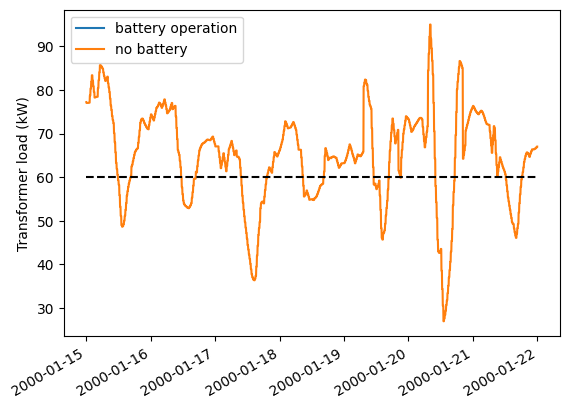

In [ ]:
deltaStart = pd.Timedelta(days=14)
deltaEnd = pd.Timedelta(days=7)

node = 'N2'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()
data['power'].loc[start:stop][node].plot(ax=ax)
data['baseline'].loc[start:stop][node].plot(ax=ax)
ax.hlines(
    y=data['baseline'][node].mean(),
    xmin=start, 
    xmax=stop, 
    linestyles='--', 
    colors='black'
)
ax.legend(['battery operation', 'no battery'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')

plt.show()

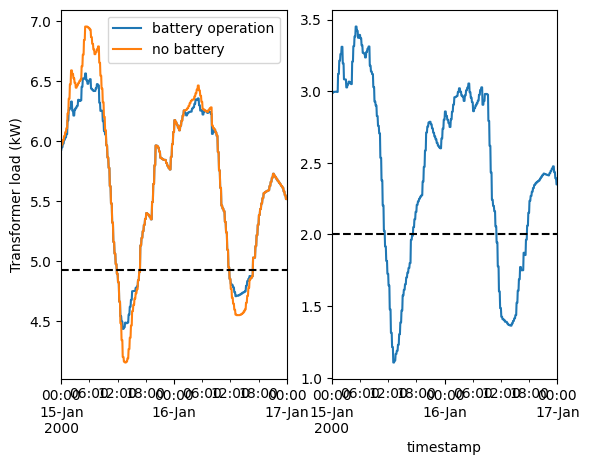

In [234]:
deltaStart = pd.Timedelta(days=14)
deltaEnd = pd.Timedelta(days=2)

node = 'N14'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, (ax1, ax2) = plt.subplots(1, 2)
data['power'].loc[start:stop][node].plot(ax=ax1)
data['baseline'].loc[start:stop][node].plot(ax=ax1)
ax1.hlines(
    y=data['baseline'][node].mean(), 
    xmin=start, 
    xmax=stop, 
    linestyles='--', 
    colors='black'
)
ax1.legend(['battery operation', 'no battery'])
ax1.set_ylabel('Transformer load (kW)')
ax1.set_xlabel('')

data['power']['price'].loc[start:stop].plot(ax=ax2)
ax2.hlines(
    y=2, 
    xmin=start, 
    xmax=stop, 
    linestyles='--',
    colors='black'
)

plt.show()

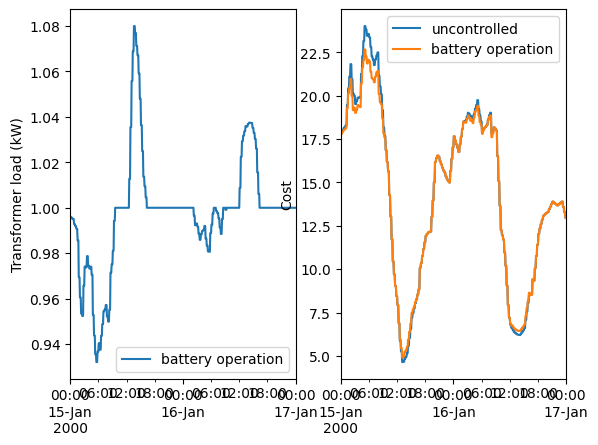

In [236]:
deltaStart = pd.Timedelta(days=14)
deltaEnd = pd.Timedelta(days=2)

node = 'N14'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, (ax1, ax2) = plt.subplots(1, 2)

compare = data['power'].loc[start:stop][node]/data['baseline'].loc[start:stop][node]
compare.plot(ax=ax1)

cost_base = data['baseline'].loc[start:stop][node]*data['power'].loc[start:stop]['price']
cost_test = data['power'].loc[start:stop][node]*data['power'].loc[start:stop]['price']
cost_base.plot(ax=ax2)
cost_test.plot(ax=ax2)

ax1.legend(['battery operation'])
ax1.set_ylabel('Transformer load (kW)')
ax1.set_xlabel('')

ax2.legend(['baseline','battery operation'])
ax2.set_ylabel('Cost')
ax2.set_xlabel('')

plt.show()

### Node voltages. The closer to 120 V, the better; the sag seen here is due to the loads being oversized for the circuit. This is more of an issue during winter months for buildings with electric heating. Selecting smaller RBSA cases will likely give better results. Imaginary parts also available in `gridlab-d/Volt_log.csv`.

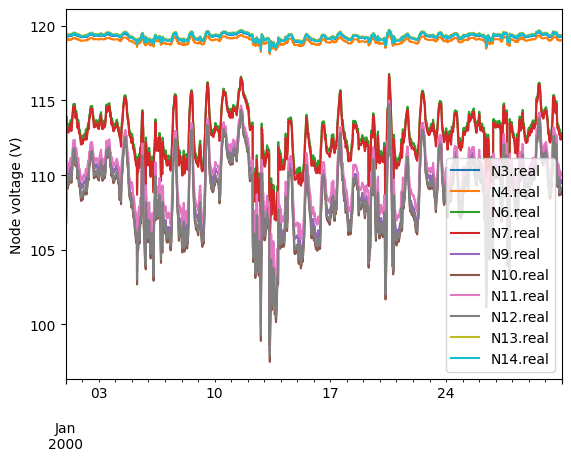

In [69]:
v = pd.read_csv('gridlab-d/Volt_log.csv', skiprows = 7, index_col = 0)
v.index.name = v.index.name.replace('# ', '')
v.columns = v.columns.str.replace(':measured_voltage_1', '')
v.index = pd.DatetimeIndex(v.index.str.replace(' PST', ''))

fig, ax = plt.subplots()
v[[column for column in v.columns if column.endswith('.real')]].plot(ax=ax)
ax.set_ylabel('Node voltage (V)')
ax.set_xlabel('')
plt.show()

### Real power losses, computed by subtracting the sum of the building nodes' consumption from the transformer consumption. For now, this data scales with demand, but that may change as more detailed ZIP coefficients and power factors are added.

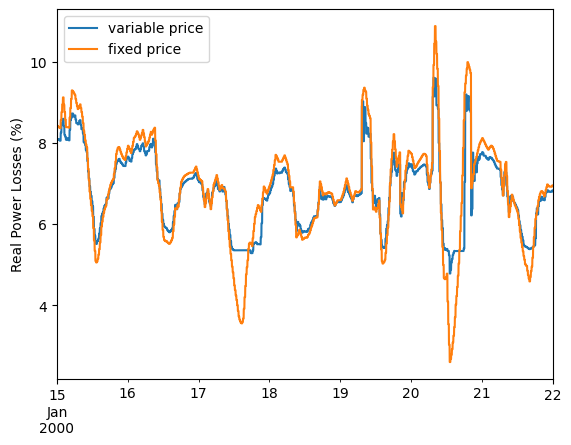

In [6]:
fig, ax = plt.subplots()
for df in [power, uncontrolled]:
    df = df.loc[start:stop]
    (100*(df.N2 - df.drop(columns='N2').sum(axis='columns'))/df.N2).plot(ax=ax)
ax.set_ylabel('Real Power Losses (%)')
ax.legend(['variable price', 'fixed price'])
ax.set_xlabel('')
plt.show()